In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [99]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [46]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

In [51]:
file_path = 'PJME_hourly.csv'
df = load_data(file_path)

In [52]:
df.head(10)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
5,2002-12-31 06:00:00,26222.0
6,2002-12-31 07:00:00,28702.0
7,2002-12-31 08:00:00,30698.0
8,2002-12-31 09:00:00,31800.0
9,2002-12-31 10:00:00,32359.0


In [53]:
# Converting 'Datetime' column to datetime format and set it as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [49]:
df.head(4)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0


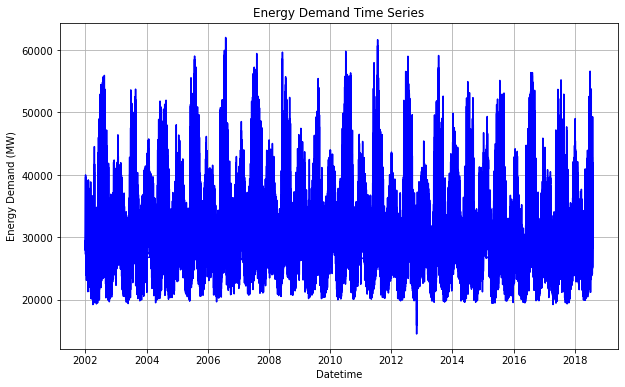

In [54]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['PJME_MW'], color='blue')
plt.title('Energy Demand Time Series')
plt.xlabel('Datetime')
plt.ylabel('Energy Demand (MW)')
plt.grid(True)
plt.show()

In [55]:
# Function to perform Augmented Dickey-Fuller test for stationarity check
def stationarity_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [56]:
# Check stationarity
print('Stationarity Test:')
stationarity_test(df['PJME_MW'])

Stationarity Test:
ADF Statistic: -18.82891272908413
p-value: 2.022124508152674e-30
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


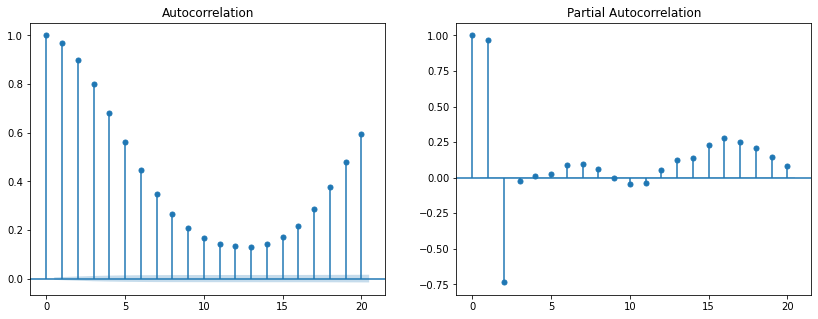

In [60]:
# Plot ACF and PACF
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(df['PJME_MW'], ax=plt.gca(), lags=20)
plt.subplot(1, 2, 2)
plot_pacf(df['PJME_MW'], ax=plt.gca(), lags=20)
plt.show()

In [61]:
# Differencing to make the series stationary
df['PJME_MW_diff'] = df['PJME_MW'] - df['PJME_MW'].shift(1)
df.dropna(inplace=True)

In [62]:
# Check stationarity of differenced series
print('Stationarity Test after Differencing:')
stationarity_test(df['PJME_MW_diff'])

Stationarity Test after Differencing:
ADF Statistic: -55.47519679928312
p-value: 0.0
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [63]:
# Splitting data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [100]:
# Fit ARIMA model
model = ARIMA(train['PJME_MW'], order=(1,1,1))
model_fit = model.fit()

In [65]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:               116292
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -980107.973
Date:                Sat, 02 Mar 2024   AIC                        1960221.946
Time:                        13:13:11   BIC                        1960250.938
Sample:                             0   HQIC                       1960230.685
                             - 116292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6690      0.002    292.887      0.000       0.664       0.673
ma.L1          0.0937      0.003     31.686      0.000       0.088       0.099
sigma2      1.224e+06   2377.346    514.891      0.0

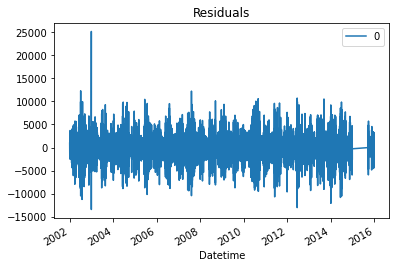

In [66]:
# Plot residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
plt.show()

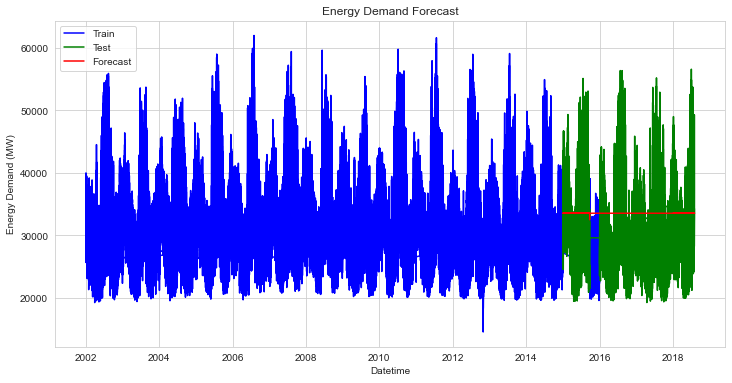

In [101]:
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")

# Plot forecast vs actual values
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['PJME_MW'], color='blue', label='Train')

# Plot test data
plt.plot(test.index, test['PJME_MW'], color='green', label='Test')

# Plot forecasted values
forecast_values = model_fit.forecast(steps=len(test))
plt.plot(test.index, forecast_values, color='red', label='Forecast')

plt.title('Energy Demand Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.grid(True)

plt.show()


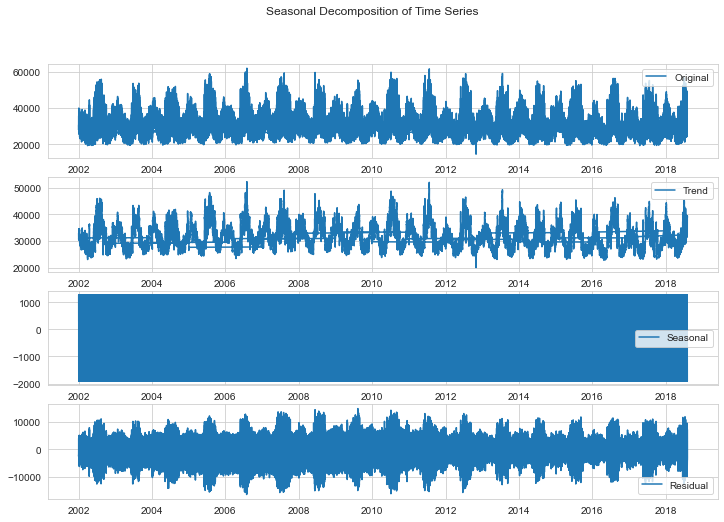

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Specify seasonal period (24 for daily seasonality)
seasonal_period = 24

# Perform seasonal decomposition of the time series
decomposition = seasonal_decompose(df['PJME_MW'], period=seasonal_period)

# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['PJME_MW'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df.index, decomposition.resid, label='Residual')
plt.legend()

plt.suptitle('Seasonal Decomposition of Time Series')
plt.show()


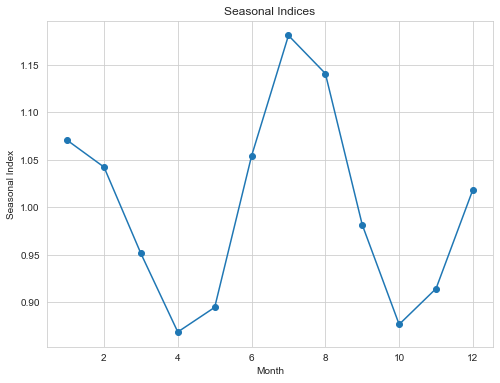

In [81]:
# Calculate seasonal indices
seasonal_index = df['PJME_MW'].groupby(df.index.month).mean() / df['PJME_MW'].mean()

# Plot seasonal indices
plt.figure(figsize=(8, 6))
plt.plot(seasonal_index.index, seasonal_index.values, marker='o', linestyle='-')
plt.title('Seasonal Indices')
plt.xlabel('Month')
plt.ylabel('Seasonal Index')
plt.grid(True)
plt.show()


In [86]:
import numpy as np

def evaluate_forecast(y_true, y_pred):
    """
    Evaluate forecast accuracy using various metrics.
    
    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.
    
    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    # Convert timestamps to integer representation
    y_true_timestamps = y_true.index.astype(int)
    y_pred_timestamps = y_pred.index.astype(int)
    
    # Calculate evaluation metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(np.diff(y_true)))
    
    # SMAPE calculation
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(numerator / denominator) * 100
    
    evaluation_metrics = {'MAPE': mape, 'MASE': mase, 'SMAPE': smape}
    return evaluation_metrics


In [88]:
forecast_values

116292    32515.197593
116293    32858.505273
116294    33088.163722
116295    33241.795599
116296    33344.568886
              ...     
145360    33552.249600
145361    33552.249600
145362    33552.249600
145363    33552.249600
145364    33552.249600
Name: predicted_mean, Length: 29073, dtype: float64

In [92]:
test['PJME_MW']

Datetime
2015-09-24 14:00:00    32634.0
2015-09-24 15:00:00    33251.0
2015-09-24 16:00:00    33741.0
2015-09-24 17:00:00    34230.0
2015-09-24 18:00:00    34075.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 29073, dtype: float64

Evaluation Metrics:
MAPE: nan
MASE: nan
SMAPE: nan


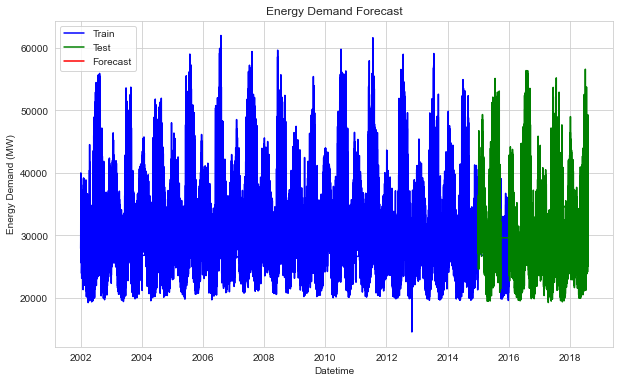

In [102]:
# Trim forecasted values to match the length of the test set and align timestamps
forecast_values_trimmed = pd.Series(forecast_values, index=test.index)

# Evaluate forecast
evaluation_metrics = evaluate_forecast(test['PJME_MW'], forecast_values_trimmed)

# Print evaluation metrics
print("Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['PJME_MW'], color='blue', label='Train')
plt.plot(test.index, test['PJME_MW'], color='green', label='Test')
plt.plot(test.index, forecast_values_trimmed, color='red', label='Forecast')
plt.title('Energy Demand Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
forecast_values_trimmed

Datetime
2015-09-24 14:00:00   NaN
2015-09-24 15:00:00   NaN
2015-09-24 16:00:00   NaN
2015-09-24 17:00:00   NaN
2015-09-24 18:00:00   NaN
                       ..
2018-01-01 20:00:00   NaN
2018-01-01 21:00:00   NaN
2018-01-01 22:00:00   NaN
2018-01-01 23:00:00   NaN
2018-01-02 00:00:00   NaN
Name: predicted_mean, Length: 29073, dtype: float64

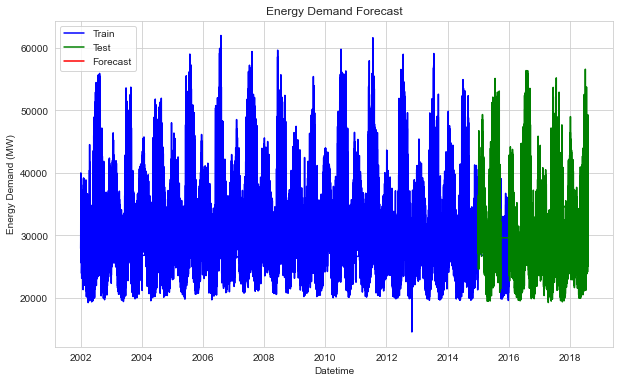

In [103]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load data
# Assuming df is your DataFrame with datetime index and 'PJME_MW' column

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train['PJME_MW'], order=(5,1,0))
model_fit = model.fit()

# Generate forecast
forecast_values = model_fit.forecast(steps=len(test))

# Trim forecasted values to match the length of the test set and align timestamps
forecast_values_trimmed = pd.Series(forecast_values, index=test.index)

# Plot forecast vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['PJME_MW'], color='blue', label='Train')
plt.plot(test.index, test['PJME_MW'], color='green', label='Test')
plt.plot(test.index, forecast_values_trimmed, color='red', label='Forecast')
plt.title('Energy Demand Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()
